# A network from the web
## step by step

1) Get data from web:

In [1]:
wikiLink='http://en.wikipedia.org/wiki/List_of_border_wars'
identification = { 'User-Agent' : 'Mozilla/5.0'} 
from requests import get
wikiPage = get(wikiLink, headers=identification)
from bs4 import BeautifulSoup as BS
wikiPage = BS(wikiPage.content,'html.parser')
wikiTables = wikiPage.findAll('table', {'class': 'sortable wikitable'})

import networkx as net
warNet=net.Graph()

#This will allow me to make edges when reading set of nodes:
from itertools import combinations

# Do this for each table
for eachTable in wikiTables: 
    # Get all the rows in the table
    allRows=eachTable.find_all("tr")
    # Do this for each row, BUT the first (the column names).
    for eachRow in range(1,len(allRows)):
        # Get all the cells
        aRow = allRows[eachRow].find_all("td")
                   
        # Getting the name of the countries 
        # in the current conflict as a list
        countries=[txt.get_text() for txt in aRow[3].find_all('a')]
        
        # Cleaning one case, and rebuilding the list
        countries=['China' if country=="PRC" or 
                        country=="People's Republic of China" 
                        else country for country in countries]
        
        # Getting the link to eah country webpage
        linksEachCountry=['http://en.wikipedia.org'+               \
           country.get('href') for country in aRow[3].find_all('a')] 
        
        # Preparing to save the coordinates of the country:
        coords=[]     
        
        # For every link collected 
        for link in linksEachCountry:
            # some cleaning:
            if link=='http://en.wikipedia.org/wiki/Soviet_Union':
                link='http://en.wikipedia.org/wiki/Russia'
            web=BS(get(link).content,'html.parser')
            # get and unpack the coordinates
            lat,lon=web.find_all("span",{'class':'geo'})[0].    \
                                          string.split('; ')
            # adding the coordinates to list
            coords.append((float(lat),float(lon))) 

        # pair up countries with its coordinates:
        countryInfo=zip(countries,coords)            
            
        #populating graph
        ## adding nodes    
        for country,(lat,lon)in countryInfo:
            warNet.add_node(country, latitude=lat,longitude=lon)
        ## creating edges:
        for pair in combinations (countries,2):
            warNet.add_edge(*pair)

2) Saving the Network in a local file:

In [2]:
net.write_graphml(warNet, "warNet.graphml",encoding='utf-8')

3) Calling the file just created:

In [3]:
warNetData=net.read_graphml("warNet.graphml")

4) Plot the Network

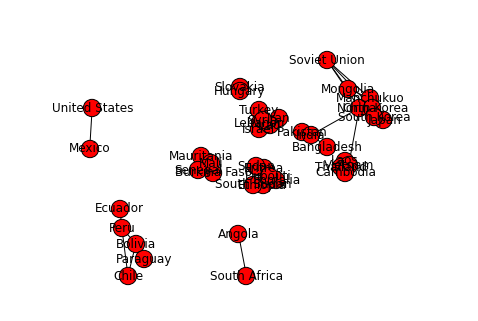

In [5]:
%matplotlib inline
X=net.get_node_attributes(warNetData,'longitude')
Y=net.get_node_attributes(warNetData,'latitude')
countryNames=warNetData.nodes()
posNet=dict((C,(X[C],Y[C])) for C in countryNames) 
net.draw(warNetData,pos=posNet,with_labels=True)

5) Nicer plot, using robinson projection:

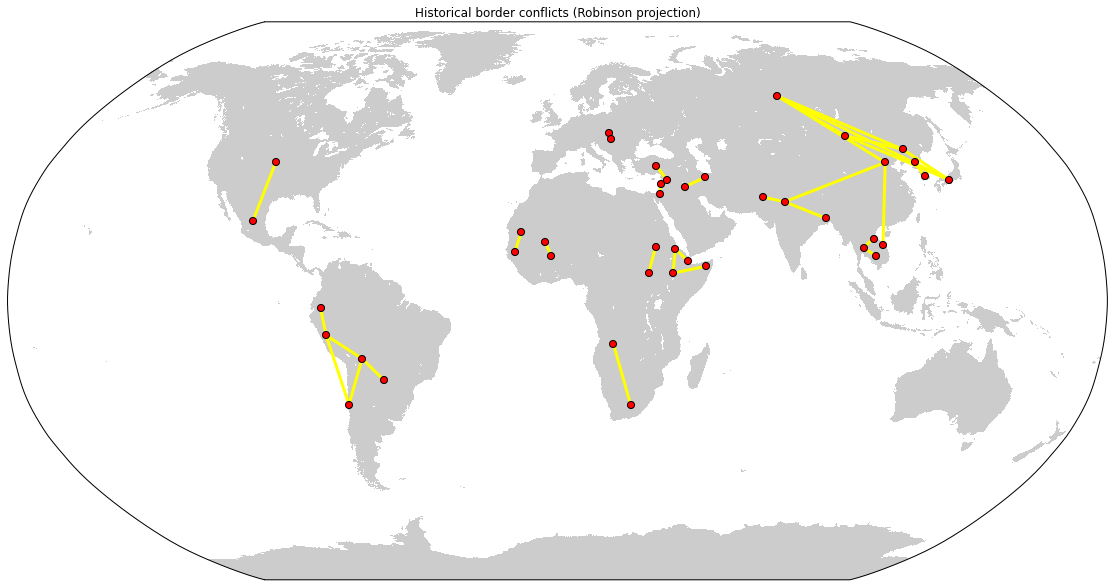

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

plt.figure(figsize=(20,10))

r = Basemap(projection='robin',lon_0=0,resolution='l')        
posRobin=dict((country,( r(X[country],Y[country]))) for country in countryNames)
net.draw_networkx_nodes(warNetData, posRobin,with_labels=True,node_size=50)
net.draw_networkx_edges(warNetData, posRobin,with_labels=False,width=3,edge_color='yellow')

r.drawlsmask() # background layer land-sea map

plt.title('Historical border conflicts (Robinson projection)')
plt.show()